# COMP4211-Tutorial 4: CNN for Image Classification
**Rui Yang, ryangam@connect.ust.hk**

## Part I: Understanding Convolution

Some figures and descriptions are credited by [Shafkat](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1).

2D convolution is a simple mathematical operation in which we slide a matrix or kernel of weights over 2D data and perform element-wise multiplication with the data that falls under the kernel. Finally, we sum up the multiplication result to produce one output of that operation.

<img src="https://miro.medium.com/max/1400/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="250" height="250"/>    <img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" width="250" height="250"/>

**Padding:** pad the edges with extra, “fake” pixels (usually of value 0, hence the oft-used term “zero padding”). This way, the kernel when sliding can allow the original edge pixels to be at its center, while extending into the fake pixels beyond the edge, producing an output the same size as the input.

<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif" width="250" height="250"/>

**Striding:**  The idea of the stride is to skip some of the slide locations of the kernel. A stride of 1 means to pick slides a pixel apart, so basically every single slide, acting as a standard convolution. A stride of 2 means picking slides 2 pixels apart, skipping every other slide in the process, downsizing by roughly a factor of 2, a stride of 3 means skipping every 2 slides, downsizing roughly by factor 3, and so on.

<img src="https://miro.medium.com/max/588/1*BMngs93_rm2_BpJFH2mS0Q.gif" width="250" height="250"/>

How to calculate the width and height of a 2D matrix convolved by a squared kernel?

W = (W_0 - K + 2P) / S + 1

H = (H_0 - K + 2P) / S + 1

In these formulas, W and H represent the width and height of the convolved output matrix, respectively. W_0 and H_0 denote the width and height of the input matrix. K represents the size of the squared kernel. P refers to the padding size, and S represents the stride.

Let's use an example image to visualize the effect of the convolution operator.

In [2]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
from PIL import Image
import requests

%matplotlib inline

In [3]:
def imshow(img, cmap='gray'):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='gray')

/var/folders/g7/mm6z5b593p798w_kj3kfj3140000gn/T/ipykernel_75592/2784031983.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  img = misc.ascent() / 255.


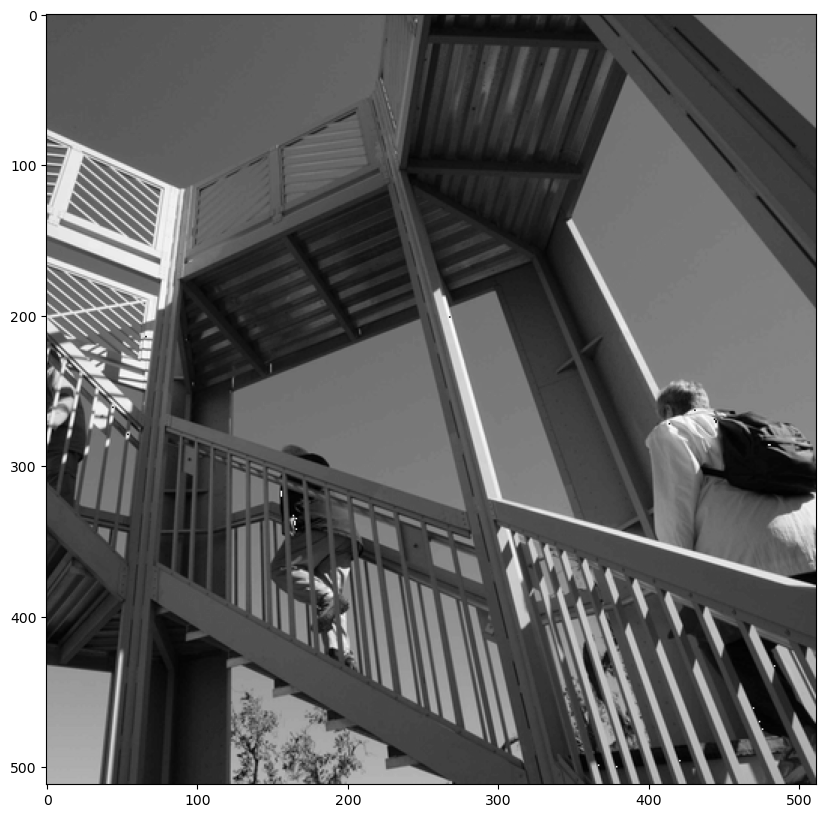

In [4]:
# change the image to an array with values between 0 and 1
img = misc.ascent() / 255.
imshow(img)

#### Sobel kernel

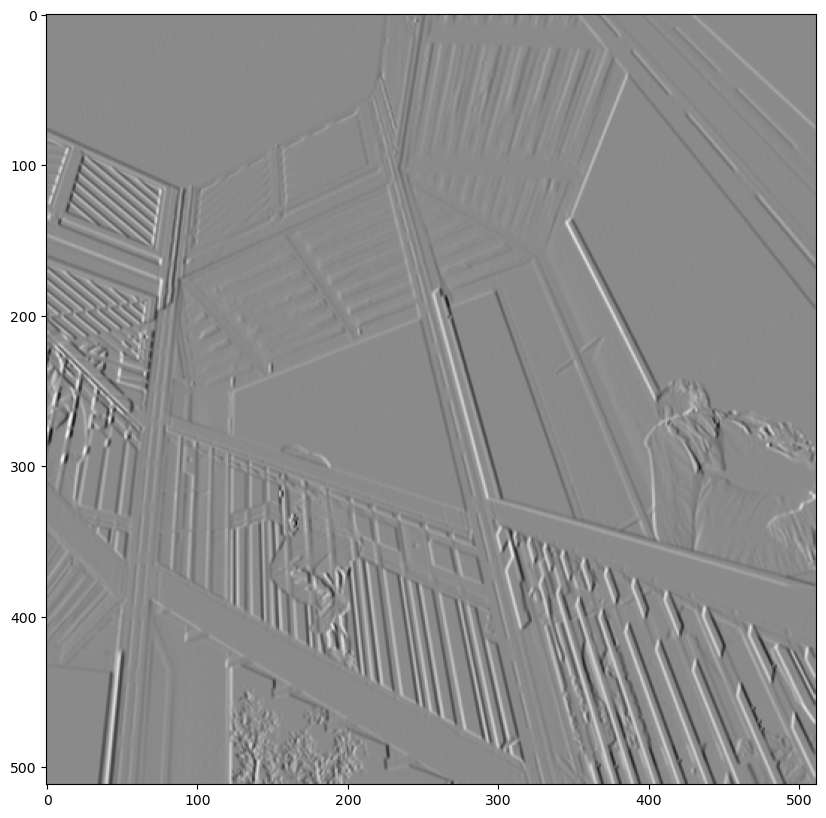

In [5]:
# Horizontal kernel to detect vertical lines
kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
dx = ndimage.convolve(img,kx)
imshow(dx)

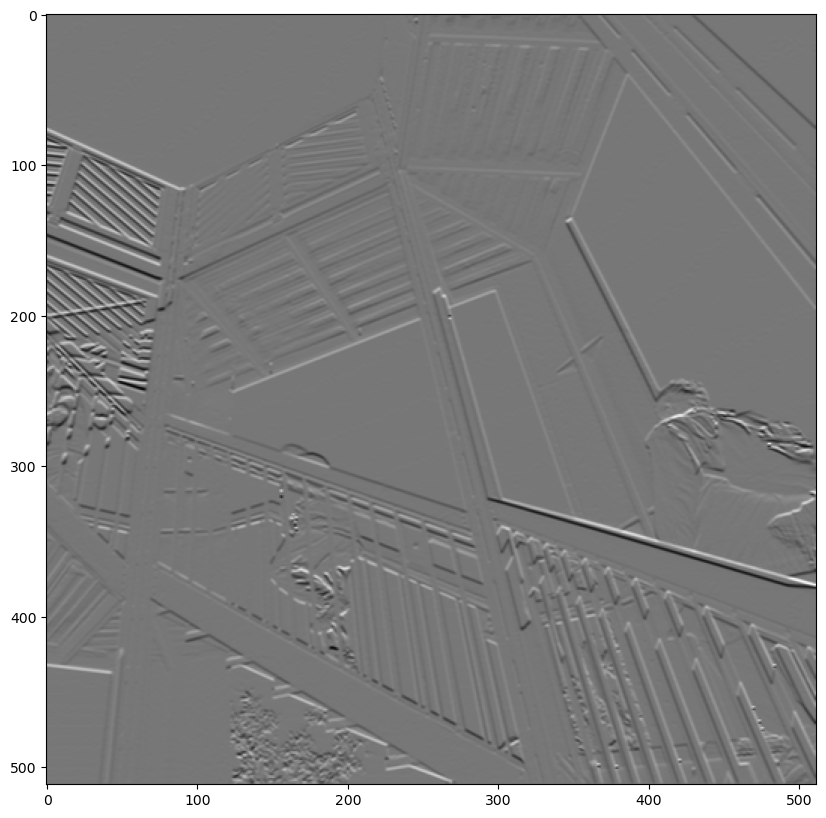

In [6]:
# Vertical kernel to detect horizontal lines
ky = np.array([[1,2,1] ,[0,0,0], [-1,-2,-1]])
dy = ndimage.convolve(img,ky)
imshow(dy)

Gradient amplitude $
\sqrt{\nabla_x^2 + \nabla_y^2}
$

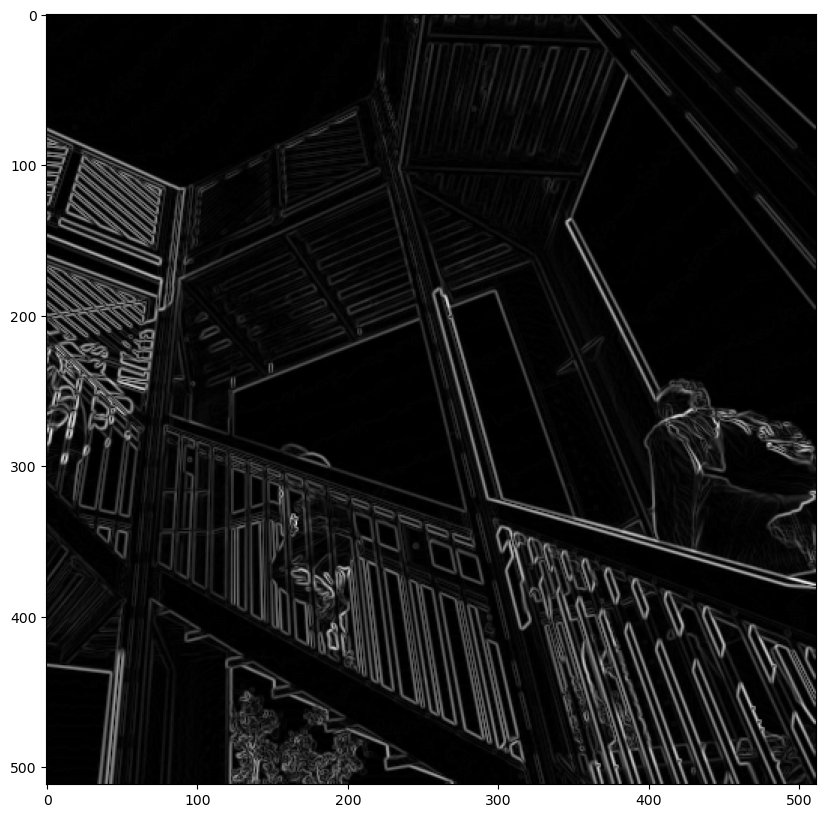

In [7]:
amp = np.sqrt(dx ** 2 + dy ** 2)
imshow(amp, cmap='gray')

#### Smoothing

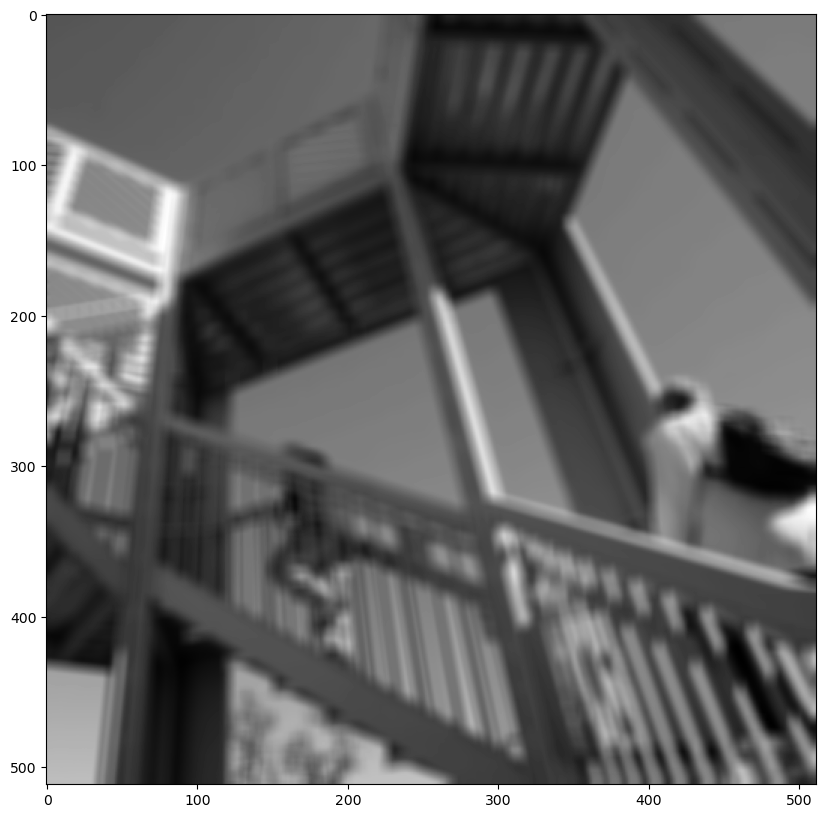

In [8]:
ks = 1/100*np.ones((10, 10))
si = ndimage.convolve(img,ks)
imshow(si)

## Part II: Training a CNN

This part is modified from [here](https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist).

### Convolution layer in PyTorch

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

* `in_channels` (int) – Number of channels in the input image

* `out_channels` (int) – Number of channels produced by the convolution

* `kernel_size` (int or tuple) – Size of the convolving kernel

* `stride` (int or tuple, optional) – Stride of the convolution. Default: 1

* `padding` (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

* `padding_mode` (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

* `dilation` (int or tuple, optional) – Spacing between kernel elements. Default: 1

* `groups` (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

* `bias` (bool, optional) – If True, adds a learnable bias to the output. Default: True

### Download MNIST

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('./mnist', train=True, download=True,transform=transform)
test_set = datasets.MNIST('./mnist', train=False, transform=transform)

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100.0%

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



### Define Dataloader

In [10]:
# Add pin_memory=True if you are using GPU
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, pin_memory=True)

### Define Model

Define a class named `Net` inherit from `nn.Module`.

In `__init__` magic function, call `super` to init its parent.

Define two `conv`'s and two `fc`'s.

`conv1` has input channel `1`, output channel `32`, square kernel size `3`, padding `1`.

`conv2` has input channel `32`, output channel `64`, square kernel size `3`, padding `1`.

`fc1` has input size `12544` ($64 \times 14 \times 14$) and output size `128`. 

`fc2` has input size `128` and output size `10`.

The `forward` function is called when data are fed into the model.

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv1 has input channel 1, output channel 32, square kernel size 3, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # conv2 has input channel 32, output channel 64, square kernel size 3, stride 1, padding 1.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # fc1 has input size 9216 = 64 * 12 * 12 and output size 128. (see forward for the input size)
        self.fc1 = nn.Linear(in_features=12544, out_features=128)
        # fc2 has input size 128 and output size 10
        self.fc2 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, x):
        # x's shape = N * 1 * 28 * 28, where N is the batch size 
        x = self.conv1(x)
        # x's shape = N * 32 * 28 * 28
        x = F.relu(x)
        # x's shape = N * 32 * 28 * 28
        x = self.conv2(x)
        # x's shape = N * 64 * 28 * 28
        x = F.relu(x)
        # x's shape = N * 64 * 28 * 28
        x = F.max_pool2d(x, 2)
        # x's shape = N * 64 * 14 * 14
        x = torch.flatten(x, 1) # flat starts from the second dim
        # x's shape = N * (64 * 14 * 14) = N * 12,544
        x = self.fc1(x)
        # x's shape =  N * 128
        x = F.relu(x)
        # x's shape =  N * 128
        x = self.fc2(x)
        # x's shape =  N * 10
        # output = F.log_softmax(x, dim=1)  # sometimes this is included in criterion
        return x

Instantiate the network

In [12]:
model = Net()

Let's see the structure of the network

In [13]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Define utils

Define optimizer - the algorithm to optimize the network. We use `SGD` with momentum 0.9 here

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Define criterion, the algorithm to calculate the loss.

We use `CrossEntropyLoss` here. It combines `LogSoftmax` and `NLLLoss`.

$l(x, y) = -\sum_i  \log y_i \frac{\exp f(x)_i}{\sum_j \exp f(x)_j}$ , where $y_i$ is the oracle probability of $x$ belonging to class $i$, and $f(x)_i$ is the prediction of $x$ belonging to class $i$. 

In [14]:
criterion = nn.CrossEntropyLoss()

### Train the model

We can use GPU to accelerate the training if GPU is available.

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


Move the model and criterion to the device.

In [16]:
model = model.to(device)
criterion = criterion.to(device)

Define a function for calculating the accuracy.

In [17]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

Now, let's start to train. We'll loop over the training dataset twice. Remember to move the training data to the corresponding device.

In [18]:
for epoch in range(2):
    running_loss = 0.0
    running_acc = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backward propagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        
        # print statistics
        if i % 100 == 99:
            average_running_loss = running_loss / 100
            average_running_acc = 100 * running_acc / 100
            print(f'[{epoch + 1}, {i+1}] loss: {average_running_loss:.3f} accuracy: {average_running_acc:.1f} %')
            running_loss = 0.0
            running_acc = 0.0

[1, 100] loss: 0.782 accuracy: 76.1 %
[1, 200] loss: 0.237 accuracy: 92.9 %
[1, 300] loss: 0.149 accuracy: 95.6 %
[1, 400] loss: 0.111 accuracy: 96.4 %
[1, 500] loss: 0.090 accuracy: 97.2 %
[1, 600] loss: 0.099 accuracy: 97.0 %
[1, 700] loss: 0.077 accuracy: 97.5 %
[1, 800] loss: 0.083 accuracy: 97.6 %
[1, 900] loss: 0.057 accuracy: 98.3 %
[2, 100] loss: 0.054 accuracy: 98.3 %
[2, 200] loss: 0.048 accuracy: 98.6 %
[2, 300] loss: 0.055 accuracy: 98.5 %
[2, 400] loss: 0.048 accuracy: 98.5 %
[2, 500] loss: 0.045 accuracy: 98.6 %
[2, 600] loss: 0.041 accuracy: 98.7 %
[2, 700] loss: 0.039 accuracy: 98.9 %
[2, 800] loss: 0.047 accuracy: 98.7 %
[2, 900] loss: 0.040 accuracy: 98.7 %


### Test the model

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test set: {100 * correct / total:.1f} %')
   

Accuracy of the network on the test set: 98.5 %


### What does each layer of the network do?

[CNN Explainer](https://poloclub.github.io/cnn-explainer/): Interactive visualization of each CNN layer. 

<img src="https://poloclub.github.io/cnn-explainer/assets/figures/softmax_animation.gif" width="700" height="700"/>